In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

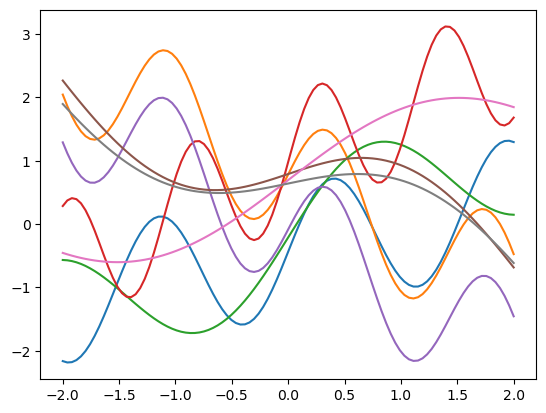

In [32]:
from data.sine_data import SineData
import matplotlib.pyplot as plt

sine_data_test = SineData(testing=True)

batch = sine_data_test.generate_batch(batch_size=8, testing=True, device='cpu')

for i in range(8):
    x = batch.target_x[i].flatten()
    y = batch.target_y[i].flatten()
    plt.plot(x.numpy(), y.numpy())
plt.show()

In [75]:
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence

def generate_knowledge(a, b, c):
    """
    a, b, c: torch.Tensor
        Shape (batch_size, 1, x_size)
    Knowledge can be none, a, b, c, ab, ac, bc 
    each vector is one-hot encoding of the parameter type with value appended to end
    e.g. if knowledge is a=1, b=0.5 then k = [1, 0, 0, 1], [0, 1, 0, 0.5]
    Returns 
    -------
    knowledge: torch.Tensor
        Shape (batch_size, num_knowledge_points, 4)
    """
    # sample types of knowledge to use as 3-vector. i.e. if ab then [1, 1, 0] if none then [0, 0, 0] etc
    binary_vector = torch.randint(0, 2, (3,))
    total_knowledge = []
    if binary_vector.sum() == 0:
        return None
    if binary_vector[0] == 1:
        # make [1, 0, 0, a]
        knowledge = torch.cat([torch.ones_like(a), torch.zeros_like(a), torch.zeros_like(a), a], dim=-1)
        total_knowledge.append(knowledge)
    if binary_vector[1] == 1:
        # make [0, 1, 0, b]
        knowledge = torch.cat([torch.zeros_like(b), torch.ones_like(b), torch.zeros_like(b), b], dim=-1)
        total_knowledge.append(knowledge)
    if binary_vector[2] == 1:
        # make [0, 0, 1, c]
        knowledge = torch.cat([torch.zeros_like(c), torch.zeros_like(c), torch.ones_like(c), c], dim=-1)
        total_knowledge.append(knowledge)
    total_knowledge = torch.cat(total_knowledge, dim=1)
    return total_knowledge



def loss_function(pred_dist: Normal, 
                  target_y: torch.Tensor,
                  posterior: Normal,
                  prior: Normal):

    batch_size, num_targets, _ = target_y.shape
    log_p = pred_dist.log_prob(target_y).sum(-1) # Shape (batch_size, num_targets)
    # assert log_p.shape[-1] == 1
    # log_p = log_p.squeeze(-1)

    kl_div = torch.sum(kl_divergence(posterior, prior), dim=-1, keepdim=True)

    loss = -torch.mean(log_p - kl_div / num_targets)
    return loss, log_p

def evaluate(model, data_generator, num_z_samples=32, num_test_batches=16, override_num_context=None, use_knowledge=False, batch_size=64):
    batch_losses = []
    device = model.device
    with torch.no_grad():
        model.training = False

        for _ in range(num_test_batches):
            batch_loss = 0
            batch = data_generator.generate_batch(batch_size=64, testing=True, override_num_context=override_num_context, device=device)
            if use_knowledge:
                knowledge = generate_knowledge(batch.a, batch.b, batch.c)
            else:
                knowledge = None
            for _ in range(num_z_samples):
                p_y_pred = model(batch.context_x, batch.context_y, knowledge, batch.target_x, batch.target_y)
                mu = p_y_pred.mean
                sigma = p_y_pred.stddev

                log_p = p_y_pred.log_prob(batch.target_y)
                log_p = log_p.mean(dim=0).mean() # Take mean over batch and mean over targets
                batch_loss += log_p
            batch_losses.append(batch_loss / num_z_samples)
    return torch.stack(batch_losses).mean().item()

InformedNeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (deterministic_encoder): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=128, bias=True)
      (13): Identity()
    )
  )
  (knowledge_encoder): KnowledgeEncoder(
    (phi): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (

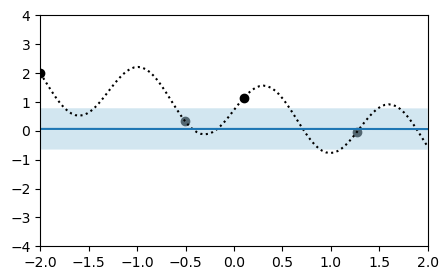

Iter: 1000, Loss 1.046311,
Iter: 2000, Loss 0.806183,


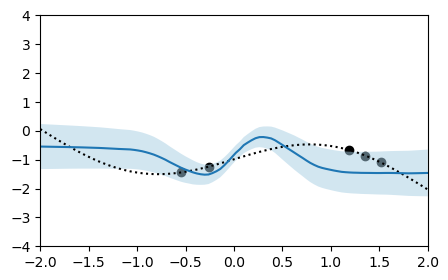

Iter: 3000, Loss 0.778293,
Iter: 4000, Loss 0.748309,


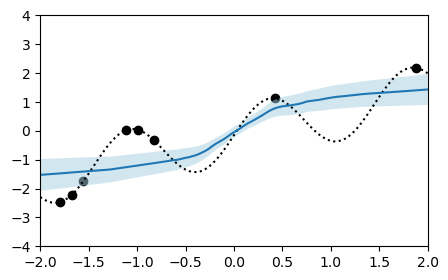

Iter: 5000, Loss 0.458889,
Iter: 6000, Loss 0.486804,


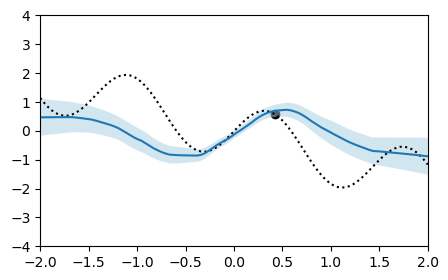

Iter: 7000, Loss 0.726003,
Iter: 8000, Loss 0.341381,


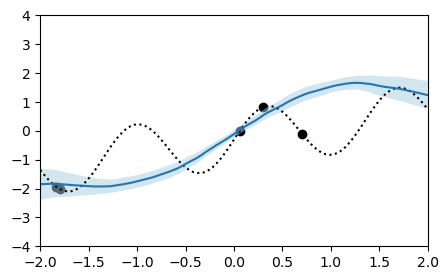

Iter: 9000, Loss -0.011620,
Iter: 10000, Loss -0.048459,


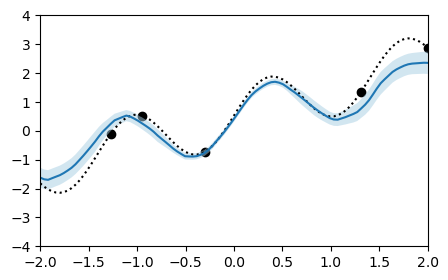

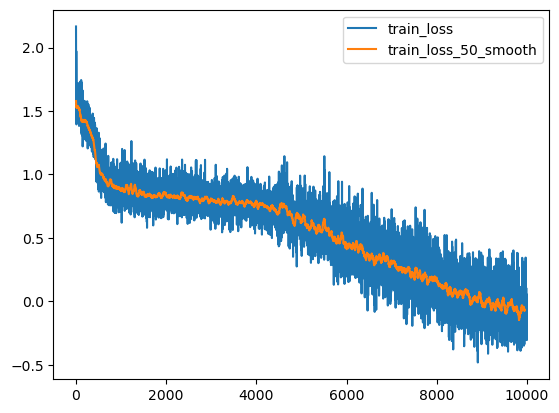

In [40]:
from src.plot import plot_predictive
from src.inp import InformedNeuralProcess

np_model = InformedNeuralProcess(
    x_size=1,
    y_size=1,
    r_size=128,
    z_size=128,
    xK_size=3,
    k_size=128,
    h_size_dec=128,
    h_size_enc_det=128,
    h_size_enc_know=128,
    h_size_agg=128,
    N_h_layers_dec=3,
    N_h_layers_enc_know_phi=2,
    N_h_layers_enc_know_rho=2,
    N_h_layers_enc_det=6,
    N_h_layers_agg=3
)
print(np_model)
print(sum(p.numel() for p in np_model.parameters() if p.requires_grad))

data = SineData()
optimiser = torch.optim.Adam(np_model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np_model.to(device)

train_loss = []
for iter in range(10000+1):
    np_model.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, q_z_target, q_z_context = np_model(batch.context_x, batch.context_y, None, batch.target_x, batch.target_y)

    loss, log_p = loss_function(p_y_pred, batch.target_y, q_z_target, q_z_context)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 1000 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f},") # NLL {nll:.6f}")
    if iter % 2000 == 0:
        np_model.training = False
        batch = data.generate_batch(1, testing=True, device=np_model.device)
        plot_predictive(np_model, batch, knowledge=None save=False, iter=None)
        np_model.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()


InformedNeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (deterministic_encoder): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): ReLU()
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): ReLU()
      (10): Linear(in_features=128, out_features=128, bias=True)
      (11): ReLU()
      (12): Linear(in_features=128, out_features=128, bias=True)
      (13): Identity()
    )
  )
  (knowledge_encoder): KnowledgeEncoder(
    (phi): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (

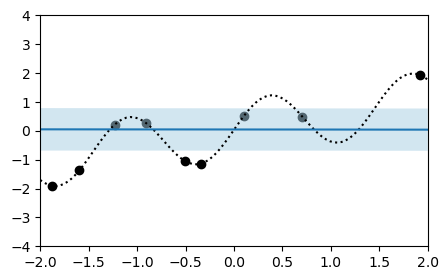

Iter: 1000, Loss 1.004816,
Iter: 2000, Loss 0.819161,


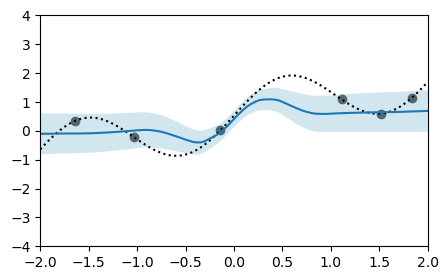

Iter: 3000, Loss 0.699027,
Iter: 4000, Loss 0.718966,


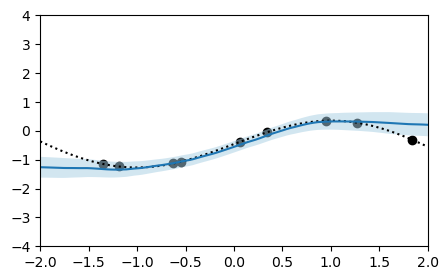

Iter: 5000, Loss 0.527668,
Iter: 6000, Loss 0.336174,


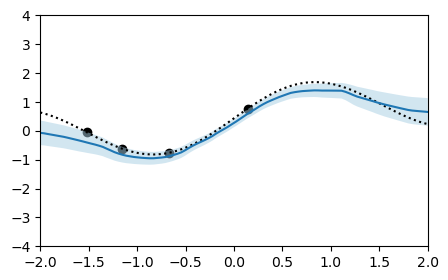

Iter: 7000, Loss 0.337541,
Iter: 8000, Loss 0.369124,


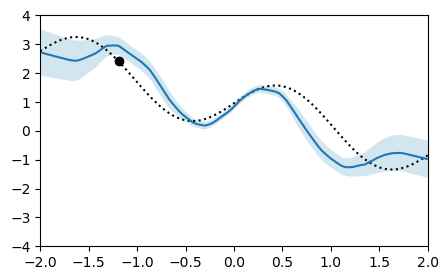

Iter: 9000, Loss 0.075685,
Iter: 10000, Loss -0.190456,


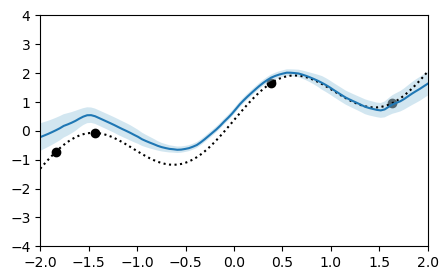

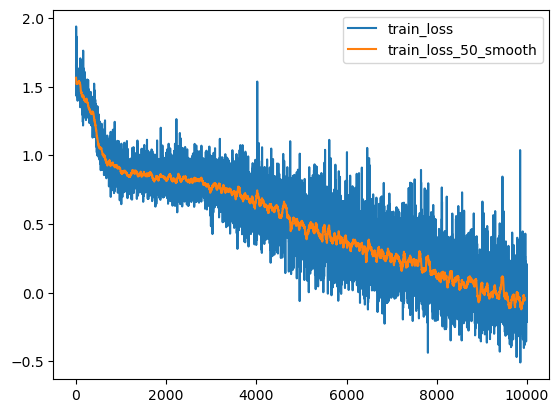

In [74]:
inf_model = InformedNeuralProcess(
    x_size=1,
    y_size=1,
    r_size=128,
    z_size=128,
    xK_size=4,
    k_size=128,
    h_size_dec=128,
    h_size_enc_det=128,
    h_size_enc_know=128,
    h_size_agg=128,
    N_h_layers_dec=3,
    N_h_layers_enc_know_phi=2,
    N_h_layers_enc_know_rho=2,
    N_h_layers_enc_det=6,
    N_h_layers_agg=3
)
print(inf_model)
print(sum(p.numel() for p in inf_model.parameters() if p.requires_grad))

optimiser = torch.optim.Adam(inf_model.parameters(), lr=1e-3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
inf_model.to(device)

train_loss = []
for iter in range(10000+1):
    inf_model.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    knowledge = generate_knowledge(batch.a, batch.b, batch.c)
    p_y_pred, q_z_target, q_z_context = inf_model(batch.context_x, batch.context_y, knowledge, batch.target_x, batch.target_y)

    loss, log_p = loss_function(p_y_pred, batch.target_y, q_z_target, q_z_context)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    if iter % 1000 == 0:
        print(f"Iter: {iter}, Loss {loss.item():.6f},") # NLL {nll:.6f}")
    if iter % 2000 == 0:
        inf_model.training = False
        batch = data.generate_batch(1, testing=True, device=inf_model.device)
        knowledge = generate_knowledge(batch.a, batch.b, batch.c)
        plot_predictive(inf_model, batch, knowledge=knowledge, save=False, iter=None)
        inf_model.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()


[NP] Num_context points: 1, Test Loss: -19.613810
[NP] Num_context points: 2, Test Loss: -13.765142
[NP] Num_context points: 3, Test Loss: -11.074625
[NP] Num_context points: 4, Test Loss: -6.709089
[NP] Num_context points: 5, Test Loss: -7.084566
[NP] Num_context points: 6, Test Loss: -4.687437
[NP] Num_context points: 7, Test Loss: -4.614048
[NP] Num_context points: 8, Test Loss: -4.630173
[NP] Num_context points: 9, Test Loss: -2.635783
[NP] Num_context points: 10, Test Loss: -2.776935
[NP] Num_context points: 11, Test Loss: -2.297745
[NP] Num_context points: 12, Test Loss: -2.352884
[NP] Num_context points: 13, Test Loss: -1.625952
[NP] Num_context points: 14, Test Loss: -1.885280
[NP] Num_context points: 15, Test Loss: -0.670694
[NP] Num_context points: 16, Test Loss: -0.658828
[NP] Num_context points: 17, Test Loss: -0.734276
[NP] Num_context points: 18, Test Loss: -0.849096
[NP] Num_context points: 19, Test Loss: -0.658041
[NP] Num_context points: 20, Test Loss: -1.041951
[INP]:

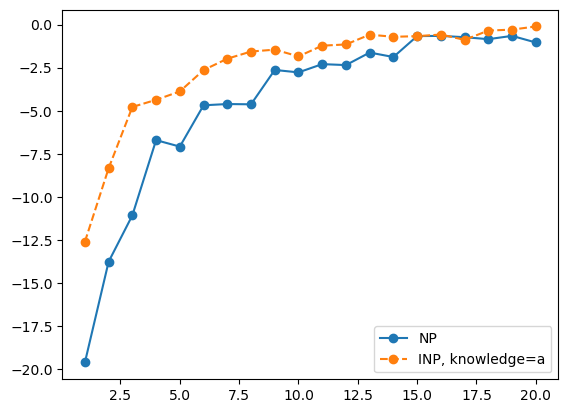

In [81]:
np_scores = []
for override_num_context in range(1, 21):
    np_test_score = evaluate(np_model, data, override_num_context=override_num_context, use_knowledge=False, batch_size=64)
    print(f"[NP] Num_context points: {override_num_context}, Test Loss: {np_test_score:.6f}")
    np_scores.append(np_test_score)

inf_scores = []
for override_num_context in range(1, 21):
    inf_test_score = evaluate(inf_model, data, override_num_context=override_num_context, use_knowledge=True, batch_size=64)
    print(f"[INP]: Num_context points: {override_num_context}, Test Loss: {inf_test_score:.6f}")
    inf_scores.append(inf_test_score)

plt.plot(range(1, 21), np_scores, "o-", label='NP')
plt.plot(range(1, 21), inf_scores, "o--", label='INP, knowledge=a')
plt.legend()
plt.show()